In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath
import networkx as nx
import itertools

from metal.label_model import LabelModel
from metal.label_model.graph_utils import JunctionTree
from metal.label_model.graph_utils import DependenciesGraph
from synthetic.generate_spa import (
    ChainDependencies,
    TreeDependencies,
    ClusterDependencies,
    DataGenerator
)
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/dfs/scratch0/paroma/anaconda2/envs/metal/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/dfs/scratch0/paroma/metal/metal/analysis.py:13: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/dfs/scratch0/paroma/anaconda2/envs/metal/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/dfs/scratch0/paroma/anaconda2/envs/metal/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/dfs/scratch0/paroma/anaconda2/envs/metal/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  F

## Generate Data by Passing in Edge List

In [2]:
def generate_edges(M, clique_size, num_cliques):
    """Given a type of dependency structure to create, returns a list of edges.

    Args:
        M: (int) Number of labeling functions 
        clique_size: (int) Maximum size of clique/block in Sigma matrix
        num_cliques: (int) Number of cliques/blocks 
    Returns:
        edges: (list) List of edge tuples
    """
    
    #Valid Input Structure
    assert M/float(clique_size) >= num_cliques
    
    edges = []
    i = 0
    while (True):
        cluster_lfs = range(i,i+clique_size)
        #edge tuples are size 2
        for comb in itertools.combinations(cluster_lfs, 2):
            edges.append(comb)
        
        #created a clique
        num_cliques-=1
        if num_cliques <= 0:   
            return edges

        #move to next LF for new clique
        i+=clique_size

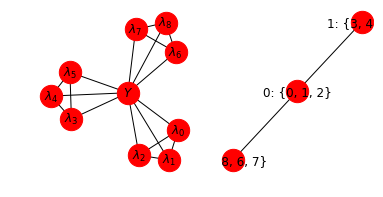

In [6]:
M = 9
N = 1000 #not used
MAX_CLIQUE_SIZE = 3
NUM_CLIQUES = 3
K = 2
HIGHER_ORDER_CLIQUES = True

# Set Graph Structure
EDGES = generate_edges(M, MAX_CLIQUE_SIZE, NUM_CLIQUES)
deps_graph = DependenciesGraph(M, EDGES)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
deps_graph.draw()


#Generate Data
data = DataGenerator(
    N,
    M,
    k=K,
    abstains=False,
    deps_graph=deps_graph,
    higher_order_cliques=HIGHER_ORDER_CLIQUES
)
plt.subplot(1,2,2)
data.jt.draw()

#get true values for later comparison, label model
sigma_O = data.get_sigma_O()
class_balance = data.get_class_balance()

## Train LabelModel with True Dependencies
Note we use the class balance and Junction Tree from the data generator since these are observable/we assume are known

In [7]:
lm = LabelModel(k=2)

lm.train(
    sigma_O=sigma_O,
    junction_tree=data.jt,
    class_balance=class_balance,
    lr=0.01,
    n_epochs=10000,
    print_every=1000
)

Estimating Z...
[E:0]	Train Loss: 30.140
[E:1000]	Train Loss: 0.000
[E:2000]	Train Loss: 0.000
[E:3000]	Train Loss: 0.000
[E:4000]	Train Loss: 0.000
[E:5000]	Train Loss: 0.000
[E:6000]	Train Loss: 0.000
[E:7000]	Train Loss: 0.000
[E:8000]	Train Loss: 0.000
[E:9000]	Train Loss: 0.000
[E:9999]	Train Loss: 0.000
Finished Training
Estimating \mu...
[E:0]	Train Loss: 7.501
[E:1000]	Train Loss: 0.000
[E:2000]	Train Loss: 0.000
[E:3000]	Train Loss: 0.000
[E:4000]	Train Loss: 0.000
[E:5000]	Train Loss: 0.000
[E:6000]	Train Loss: 0.000
[E:7000]	Train Loss: 0.000
[E:8000]	Train Loss: 0.000
[E:9000]	Train Loss: 0.000
[E:9999]	Train Loss: 0.000
Finished Training


## Measure Error in True and Estimated $\mu$
Given the following:
$$\Sigma = \begin{bmatrix} \Sigma_O & \Sigma_{OH} \\ \Sigma_{HO} & \Sigma_H \end{bmatrix} $$

we want to focus on $$\Sigma_{OH} = \mathbb{E}[\lambda_i Y] - \mathbb{E}[\lambda_i]\mathbb{E}[Y]$$

where $\mathbb{E}[\lambda_i Y]$ are the LF accuracies, $\mathbb{E}[\lambda_i]$ are the observed label propensities, and $\mathbb{E}[Y]$ is the observed/known class balance.

In [11]:
sigma_O_inv = np.linalg.inv(sigma_O)
sigma_H = data.P_marginal({M:2})

mu = data.get_mu()
mu_x = sigma_H * np.array([data.P_marginal(v) for i, v in data.jt.iter_observed()])
sigma_OH = mu - mu_x

SIGN_FLIP = -1 #For better than random assumption
mu_est = SIGN_FLIP * lm.mu.detach().numpy() + mu_x.reshape([-1,1])
np.hstack([mu_est, mu.reshape([-1, 1])])

print ("Error in mu: ", np.mean(np.abs(mu - mu_est.ravel())))

Error in mu:  0.003413439081926641
